# Assessing the Impact of Context Inference Error and Partial Observability on RL Methods for Just-In-Time Adaptive Interventions

# <a href="https://colab.research.google.com/github/reml-lab/rl_jitai_simulation/blob/main/examples/rl_jitai_simulation_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an official notebook for the paper **"Assessing the Impact of Context Inference Error and Partial Observability on RL Methods for Just-In-Time Adaptive Interventions"**, accepted at UAI 2023.

**Paper links**: the arXiv version and the published paper links are:

+ [arXiv link](https://arxiv.org/abs/2305.09913)
+ [UAI 2023 link](https://proceedings.mlr.press/v216/karine23a.html)

**Paper abstract**:
Just-in-Time Adaptive Interventions (JITAIs) are a class of personalized health interventions developed within the behavioral science community. JITAIs aim to provide the right type and amount of support by iteratively selecting a sequence of intervention options from a pre-defined set of components in response to each individual's time varying state. In this work, we explore the application of reinforcement learning methods to the problem of learning intervention option selection policies. We study the effect of context inference error and partial observability on the ability to learn effective policies. Our results show that the propagation of uncertainty from context inferences is critical to improving intervention efficacy as context uncertainty increases, while policy gradient algorithms can provide remarkable robustness to partially observed behavioral state information.

**This notebook**: we describe how to reproduce similar results to the paper.

# Initialize Code

In [ ]:
!pip install rl_jitai_simulation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from tqdm import tqdm
DASH = '----------------------------------------------------------'

In [ ]:
from RL.rl_jitai_simulation.envs import JITAI_env
from RL.rl_jitai_simulation.agents import ReinforceAgent, DQNAgent

# 1. Introduction

We provide a description of the JITAI Simulation Environment, and the code to run an RL loop, using DQN and REINFORCE.

## 1.1 Description of the JITAI Simulation Environment

+ JITAI env produces various observations variables (obs). The possible obs names are: ```'C', 'P', 'L', 'H', 'D', 'T'```. These can be set using ```chosen_obs_names```, for example: ```chosen_obs_names=['C','H','D']```, ```['L','H','D']``` or ```['P','T']```, etc., where C is for true contex, P is for probability of context=0, L is for inferred context, H is for habituation, D is for disengagement and T is the binary indicator. Note that all obs samples are augmented by the time inhomogeneous vector, as described in the paper.

+ There are 4 possible actions (action values are: ```0,1,2,3```).

+ JITAI env default parameters are: habituation decay ```δh=0.1```, habituation increment  ```εh=0.05```, disengagement decay ```δd=0.1```, disengagement increment ```εd=0.1```, base reward (for $a_t=1$) ```ρ1=50```, base reward (for $a_t=c_t+2$) ```ρ2=200```. The feature uncertainty ```sigma``` values are: ```0, 0.4,..., 2```.

+ JITAI env is built on top of OpenAI gym environment, and can be plugged in as an Open AI gym environment in an RL loop.

## 1.2 Code to run RL loop for DQN and REINFORCE

In [ ]:
def run_RL_loop_DQN(env, agent, n_episodes, b_train, b_plot=False, plot_title='', y_lim=(-200,3500)):
  return_values = []
  for i in tqdm(range(n_episodes), desc ="DQN {} σ={} duration".format(env.chosen_obs_names_str, env.sigma)):
    obs = env.reset()
    return_value = 0
    done = False
    while not done:
      action = agent.choose_action(obs)
      obs_, reward, done, info = env.step(action)
      agent.observe(obs, action, reward, obs_, done)
      if b_train: agent.update()
      obs = obs_
      return_value += reward
    return_values.append(return_value)
  if b_plot:
    plt.figure(figsize=(3,2))
    plt.plot(return_values)
    if len(plot_title) < 1:
      plot_title = ' (σ={})'.format(env.sigma)
    plt.title('DQN {} learning{}'.format(env.chosen_obs_names_str, plot_title))
    plt.ylim(y_lim); plt.xlabel('episode'); plt.ylabel('return'); plt.grid(); plt.show()
  return return_values

def run_RL_loop_REINFORCE(env, agent, M, n_episodes, b_train, b_plot=False, plot_title='', y_lim=(-200,3500)):
  return_values = []
  for i in tqdm(range(n_episodes), desc ="REINFORCE {} σ={} duration".format(env.chosen_obs_names_str, env.sigma)):
    if b_train: agent.init_grad()
    return_samples = []
    for m in range(M):
      obs = env.reset()
      return_sample = 0
      done = False
      while not done:
        action = agent.choose_action(obs)
        obs_, reward, done, info = env.step(action)
        agent.store_rewards(reward)
        obs = obs_
        return_sample += reward
      return_samples.append(return_sample)
      if b_train: agent.compute_grad()
    if b_train: agent.take_step(env.max_episode_length)
    return_values.append(np.mean(return_samples))
  if b_plot:
    plt.figure(figsize=(3,2))
    plt.plot(return_values)
    if len(plot_title) < 1:
      plot_title = ' (σ={})'.format(env.sigma)
    plt.title('REINFORCE {} learning{}'.format(env.chosen_obs_names_str, plot_title))
    plt.ylim(y_lim); plt.xlabel('episode'); plt.ylabel('return'); plt.grid(); plt.show()
  return return_values

def set_random_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)

def  get_key(sigma, δd, εd, seed, chosen_obs_name):
  str_detail = 'σ={} δd={} εd={} seed={} obs={}'.format(sigma, δd, εd, seed, '-'.join(chosen_obs_name))
  str_key = str_detail.replace('.','').replace(' ','_').replace('-','').replace('=','')
  return str_key

# 2. How to reproduce similar results to the paper

To reproduce the results of the paper, you can choose larger number of episodes, repeats and M (REINFORCE number of samples), as indicated in the paper. Below, the number of episodes and repeats have been reduced to shorten the experiment durations in this notebook.

## 2.1 Get the experiment configuration

In [ ]:
n_episodes_dqn = 500
n_episodes_reinforce = 5000
n_episodes_perf = 1000
sigma_list = [0, 0.4, 0.6, 0.8, 2]
chosen_obs_list = [['P','H','D'], ['L','H','D']]
δd = 0.1
εd = 0.4

## 2.2 Run the experiments, over the $\sigma$ values

### 2.2.1 JITAI env, with DQN

In [ ]:
perf_DQN = {}
for sigma in sigma_list:
  for chosen_obs_name in chosen_obs_list:
    for seed in [0]:
      str_key =  get_key(sigma, δd, εd, seed, chosen_obs_name)
      set_random_seed(seed)
      env0 = JITAI_env(sigma=sigma, δd=δd, εd=εd, chosen_obs_names=chosen_obs_name)
      agent0 = DQNAgent(gamma=1, lr=5e-4, batch_size=64, input_dims=[env0.get_obs_length()], n_actions=4, fc1_dim=128, fc2_dim=128)
      train_returns = run_RL_loop_DQN(env0, agent0, n_episodes_dqn,  b_train=True)
      perf_returns  = run_RL_loop_DQN(env0, agent0, n_episodes_perf, b_train=False)
      print('DQN {} σ={} returns len={} mean={:.1f}'.format(env0.chosen_obs_names_str, sigma, len(perf_returns), np.mean(perf_returns)))
      perf_DQN[str_key] = perf_returns
      print(DASH)

env config: obs=P-H-D σ=0 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


DQN P-H-D σ=0 duration: 100%|██████████| 1000/1000 [01:02<00:00, 16.06it/s]


DQN P-H-D σ=0 returns len=1000 mean=3192.5
----------------------------------------------------------
env config: obs=L-H-D σ=0 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


DQN L-H-D σ=0 duration: 100%|██████████| 1000/1000 [01:02<00:00, 16.12it/s]


DQN L-H-D σ=0 returns len=1000 mean=3272.4
----------------------------------------------------------
env config: obs=P-H-D σ=0.4 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


DQN P-H-D σ=0.4 duration: 100%|██████████| 1000/1000 [01:13<00:00, 13.66it/s]


DQN P-H-D σ=0.4 returns len=1000 mean=3053.7
----------------------------------------------------------
env config: obs=L-H-D σ=0.4 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


DQN L-H-D σ=0.4 duration: 100%|██████████| 1000/1000 [01:05<00:00, 15.24it/s]


DQN L-H-D σ=0.4 returns len=1000 mean=2549.6
----------------------------------------------------------
env config: obs=P-H-D σ=0.6 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


DQN P-H-D σ=0.6 duration: 100%|██████████| 1000/1000 [01:05<00:00, 15.28it/s]


DQN P-H-D σ=0.6 returns len=1000 mean=2542.1
----------------------------------------------------------
env config: obs=L-H-D σ=0.6 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


DQN L-H-D σ=0.6 duration: 100%|██████████| 1000/1000 [00:42<00:00, 23.41it/s]


DQN L-H-D σ=0.6 returns len=1000 mean=1665.0
----------------------------------------------------------
env config: obs=P-H-D σ=0.8 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


DQN P-H-D σ=0.8 duration: 100%|██████████| 1000/1000 [00:50<00:00, 19.85it/s]


DQN P-H-D σ=0.8 returns len=1000 mean=1766.3
----------------------------------------------------------
env config: obs=L-H-D σ=0.8 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


DQN L-H-D σ=0.8 duration: 100%|██████████| 1000/1000 [00:29<00:00, 34.12it/s]


DQN L-H-D σ=0.8 returns len=1000 mean=1206.8
----------------------------------------------------------
env config: obs=P-H-D σ=2 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


DQN P-H-D σ=2 duration: 100%|██████████| 1000/1000 [01:12<00:00, 13.81it/s]


DQN P-H-D σ=2 returns len=1000 mean=670.4
----------------------------------------------------------
env config: obs=L-H-D σ=2 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


DQN L-H-D σ=2 duration: 100%|██████████| 1000/1000 [01:04<00:00, 15.55it/s]

DQN L-H-D σ=2 returns len=1000 mean=730.6
----------------------------------------------------------


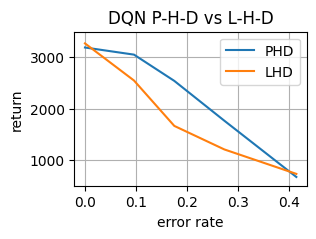

In [ ]:
xs = []; ys_PHD = []; ys_LHD = []
for chosen_sigma in sigma_list:
  ys_PHD.append(np.mean(perf_DQN[get_key(chosen_sigma, δd, εd, seed=0, chosen_obs_name='PHD')]))
  ys_LHD.append(np.mean(perf_DQN[get_key(chosen_sigma, δd, εd, seed=0, chosen_obs_name='LHD')]))
  xs.append(env0.get_inferred_error(chosen_sigma))
plt.figure(figsize=(3,2))
plt.plot(xs, ys_PHD, label='PHD')
plt.plot(xs, ys_LHD, label='LHD')
plt.title('DQN P-H-D vs L-H-D'); plt.xlabel('error rate'); plt.ylabel('return')
plt.ylim(500,3500); plt.grid(); plt.legend(); plt.show()

### 2.2.2 JITAI env, with REINFORCE

In [ ]:
perf_REINFORCE = {}
for sigma in sigma_list:
  for chosen_obs_name in chosen_obs_list:
    for seed in [0]:
      str_key =  get_key(sigma, δd, εd, seed, chosen_obs_name)
      set_random_seed(seed)
      env1 = JITAI_env(sigma=sigma, δd=δd, εd=εd, chosen_obs_names=chosen_obs_name)
      agent1 = ReinforceAgent(gamma=1, lr=6e-4, input_dims=[env1.get_obs_length()], n_actions=4, fc1_dim=128, fc2_dim=None)
      train_returns = run_RL_loop_REINFORCE(env1, agent1, M=1, n_episodes=n_episodes_reinforce, b_train=True)
      perf_returns  = run_RL_loop_REINFORCE(env1, agent1, M=1, n_episodes=n_episodes_perf,      b_train=False)
      print('REINFORCE {} σ={} returns len={} mean={:.1f}'.format(env1.chosen_obs_names_str, sigma, len(perf_returns), np.mean(perf_returns)))
      perf_REINFORCE[str_key] = perf_returns
      print(DASH)

env config: obs=P-H-D σ=0 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


REINFORCE P-H-D σ=0 duration: 100%|██████████| 1000/1000 [01:27<00:00, 11.45it/s]


REINFORCE P-H-D σ=0 returns len=1000 mean=3127.7
----------------------------------------------------------
env config: obs=L-H-D σ=0 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


REINFORCE L-H-D σ=0 duration: 100%|██████████| 1000/1000 [01:23<00:00, 11.95it/s]


REINFORCE L-H-D σ=0 returns len=1000 mean=3062.3
----------------------------------------------------------
env config: obs=P-H-D σ=0.4 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


REINFORCE P-H-D σ=0.4 duration: 100%|██████████| 1000/1000 [01:32<00:00, 10.78it/s]


REINFORCE P-H-D σ=0.4 returns len=1000 mean=2775.9
----------------------------------------------------------
env config: obs=L-H-D σ=0.4 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


REINFORCE L-H-D σ=0.4 duration: 100%|██████████| 1000/1000 [01:24<00:00, 11.80it/s]


REINFORCE L-H-D σ=0.4 returns len=1000 mean=2514.0
----------------------------------------------------------
env config: obs=P-H-D σ=0.6 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


REINFORCE P-H-D σ=0.6 duration: 100%|██████████| 1000/1000 [01:24<00:00, 11.86it/s]


REINFORCE P-H-D σ=0.6 returns len=1000 mean=2054.7
----------------------------------------------------------
env config: obs=L-H-D σ=0.6 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


REINFORCE L-H-D σ=0.6 duration: 100%|██████████| 1000/1000 [01:04<00:00, 15.60it/s]


REINFORCE L-H-D σ=0.6 returns len=1000 mean=1767.6
----------------------------------------------------------
env config: obs=P-H-D σ=0.8 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


REINFORCE P-H-D σ=0.8 duration: 100%|██████████| 1000/1000 [01:28<00:00, 11.26it/s]


REINFORCE P-H-D σ=0.8 returns len=1000 mean=1458.4
----------------------------------------------------------
env config: obs=L-H-D σ=0.8 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


REINFORCE L-H-D σ=0.8 duration: 100%|██████████| 1000/1000 [01:18<00:00, 12.74it/s]


REINFORCE L-H-D σ=0.8 returns len=1000 mean=1504.7
----------------------------------------------------------
env config: obs=P-H-D σ=2 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


REINFORCE P-H-D σ=2 duration: 100%|██████████| 1000/1000 [01:30<00:00, 11.06it/s]


REINFORCE P-H-D σ=2 returns len=1000 mean=1077.5
----------------------------------------------------------
env config: obs=L-H-D σ=2 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


REINFORCE L-H-D σ=2 duration: 100%|██████████| 1000/1000 [01:31<00:00, 10.88it/s]

REINFORCE L-H-D σ=2 returns len=1000 mean=1118.9
----------------------------------------------------------


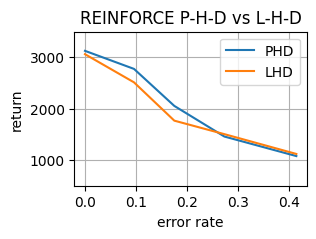

In [ ]:
xs = []; ys_PHD = []; ys_LHD = []
for chosen_sigma in sigma_list:
  sigma_str = str(chosen_sigma).replace('.','')
  ys_PHD.append(np.mean(perf_REINFORCE[get_key(chosen_sigma, δd, εd, seed=0, chosen_obs_name='PHD')]))
  ys_LHD.append(np.mean(perf_REINFORCE[get_key(chosen_sigma, δd, εd, seed=0, chosen_obs_name='LHD')]))
  xs.append(env1.get_inferred_error(chosen_sigma))
plt.figure(figsize=(3,2))
plt.plot(xs, ys_PHD, label='PHD')
plt.plot(xs, ys_LHD, label='LHD')
plt.title('REINFORCE P-H-D vs L-H-D'); plt.xlabel('error rate'); plt.ylabel('return')
plt.ylim(500,3500); plt.grid(); plt.legend(); plt.show()